<a href="https://colab.research.google.com/github/kruttikajain/Targetted-Abusive_Language_Online/blob/master/prediction1_fox_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abusive Language Online 

Predition1: predict OFF/NOT

* Upload it each time: Dataset: [data](http://demo.clab.cs.cmu.edu/ethical_nlp2019/homeworks/hw3/hw3.html)


1.   train.tsv
2.   dev.tsv
3.   test.tsv

* Need manually add log.txt
* Mount drive to load GloVe embeddings




# Import useful lib

In [1]:
import os
import sys
from logging import handlers
from pathlib import Path
import logging
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import random 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, CuDNNLSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data proprecessing

## mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pwd

/content


In [4]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '' 
# replace with your Github username 
GIT_USERNAME = "kruttikajain" 
# definitely replace with your
GIT_TOKEN = "5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "Targetted-Abusive_Language_Online" 

# PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

'''
only this line should be modify
'''
PROJECT_PATH = './gdrive/My Drive/Colab Notebooks/246Project'

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  ./gdrive/My Drive/Colab Notebooks/246Project
mkdir: cannot create directory ‘./gdrive/My Drive/Colab Notebooks/246Project’: File exists
GIT_PATH:  https://5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c@github.com/kruttikajain/Targetted-Abusive_Language_Online.git


## Prepare logging file

In [5]:
def init_logger(log_file):
    if not os.path.exists(log_file):
        os.makedirs(os.path.dirname(log_file))

    log = logging.getLogger('')
    log.setLevel(logging.INFO)
    output_format = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    std_out_handler = logging.StreamHandler(sys.stdout)
    std_out_handler.setFormatter(output_format)
    logging.getLogger().addHandler(std_out_handler)
    file_handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=(1048576*5), backupCount=7)
    file_handler.setFormatter(output_format)
    logging.getLogger().addHandler(file_handler)

init_logger(PROJECT_PATH + '/log.txt')
logging.info('=============start2=================')
logging.info('logging file prepared...')

2020-05-24 00:59:27 INFO     =============start2=================
2020-05-24 00:59:27 INFO     logging file prepared...


## load data

In [20]:
def load_data():
    logging.info('loading the dataset...')
    train_df = pd.read_csv(PROJECT_PATH + '/project_data/train.tsv', sep="\t")
    val_df = pd.read_csv(PROJECT_PATH + '/project_data/dev.tsv', sep="\t")
    # fox-news dataset
    test_df = pd.read_json(PROJECT_PATH + '/project_data/fox-news-comments.json', lines=True)
    
    
    # shape of df, column names
    logging.info('Train shape : ' + str(train_df.shape)) # 'text', 'label', 'category'
    logging.info('Val shape: ' + str(val_df.shape))
    logging.info('Test shape: ' + str(test_df.shape))
    
    logging.info('train_df.columns: ' + train_df.columns)
    logging.info('val_df.columns: ' + val_df.columns)
    logging.info('test_df.columns: ' + test_df.columns)

    return train_df, val_df, test_df

train_df, val_df, test_df = load_data()

2020-05-24 01:16:15 INFO     loading the dataset...
2020-05-24 01:16:15 INFO     Train shape : (10592, 3)
2020-05-24 01:16:15 INFO     Val shape: (1324, 3)
2020-05-24 01:16:15 INFO     Test shape: (1528, 8)
2020-05-24 01:16:15 INFO     Index(['train_df.columns: text', 'train_df.columns: label',
       'train_df.columns: category'],
      dtype='object')
2020-05-24 01:16:15 INFO     Index(['val_df.columns: text', 'val_df.columns: label',
       'val_df.columns: category'],
      dtype='object')
2020-05-24 01:16:15 INFO     Index(['test_df.columns: title', 'test_df.columns: text',
       'test_df.columns: label', 'test_df.columns: succ',
       'test_df.columns: meta', 'test_df.columns: user',
       'test_df.columns: mentions', 'test_df.columns: prev'],
      dtype='object')


**Attributes in data:**


***Trainning data:***  (10592, 3) \\

* **text:** \\
tweet content

* **label:** \\
1.   (NOT) Not Offensive - This post does not contain offense or profanity
2.   (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

* **category:** (if label is 'OFF') \\
1.   (TIN) Targeted Insult and Threats - A post containing an insult or threat to an individual, a group, or others
2.   (UNT) Untargeted - A post containing non-targeted profanity and swearing.

***Validation data:***  (1324, 3) \\

***Testing data***:  'text' (1324, 1) \\
* **text**

## Data cleaning

In [21]:
def data_cleaning(train_df, val_df, test_df):

    # drop useless columns
    test_df = test_df[['text', 'label']]

    # shuffle data
    train_df = train_df.sample(frac=1, random_state=2020).reset_index(drop=True)
    
    # lo lowercae
    train_df['text'] = train_df['text'].str.lower()
    val_df['text'] = val_df['text'].str.lower()
    test_df['text'] = test_df['text'].str.lower()

    # delete "noise words"
    noise = ["url","user","@","&amp;","#","-",'.',"!","?","rt","dm","retweet","rt","dm"]
    for WORD in noise:
        train_df['text'] = train_df['text'].str.replace(WORD, '')
        val_df['text'] = val_df['text'].str.replace(WORD, '')
        test_df['text'] = test_df['text'].str.replace(WORD, '')

    # change label to 0/a
    train_df['label'] = train_df['label'].map({'OFF': 1, 'NOT': 0})
    val_df['label'] = val_df['label'].map({'OFF': 1, 'NOT': 0})

    # one-hot encoding of category
    train_df = pd.concat([train_df,pd.get_dummies(train_df['category'], prefix='category')],axis=1)
    train_df.drop(['category'],axis=1, inplace=True)
    
    val_df = pd.concat([val_df,pd.get_dummies(val_df['category'], prefix='category')],axis=1)
    val_df.drop(['category'],axis=1, inplace=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = data_cleaning(train_df, val_df, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Data distribution and visualization 

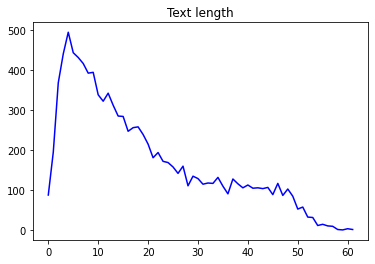

2020-05-24 01:16:41 INFO     number of label = 1 : 3520
2020-05-24 01:16:41 INFO     number of category_TIN = 1: 3089
2020-05-24 01:16:41 INFO     number of category_UNT = 1: 431


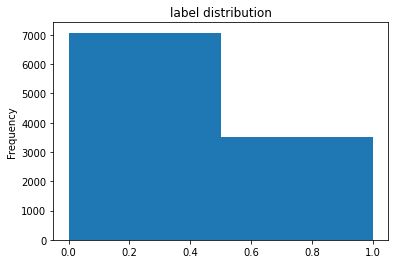

In [22]:
# count how many letters in a sentence
def label_distribution(train_df):
    #  length of text
    count = train_df['text'].str.split().apply(len).value_counts()
    count.sort_index(inplace=True)
    count.index = count.index.astype(str) + ' words:'
    # logging.info(count[0:5])
    # logging.info(count[-5:])
    plt.plot(range(len(count)), count, color='blue')
    plt.title("Text length")
    plt.show()
    # label distribution
    logging.info('number of label = 1 : ' + str((train_df['label'] != 0).sum()))
    logging.info('number of category_TIN = 1: ' + str((train_df['category_TIN'] != 0).sum()))
    logging.info('number of category_UNT = 1: ' + str((train_df['category_UNT'] != 0).sum()))

    # plot histogram
    train_df['label'].plot.hist(bins=2, title='label distribution')
    plt.show()

label_distribution(train_df)


**Property of dataset**

*   **Length of text:** [2, 60]

*   **label:** 
1.   label = 0: 7072
2.   label = 1: 3520

* Among label = 1: \\
1.   category_TIN = 1: 3089
2.   category_UNT = 1: 431



# Split data to X and y

Split data to X and y

In [23]:
def split_train_val(train_df, val_df, test_df):
    logging.info('splitting X and y ...')
    train_X = train_df["text"].fillna("_na_").values
    val_X = val_df["text"].fillna("_na_").values
    test_X = test_df["text"].fillna("_na_").values

    train_y = train_df['label'].values
    val_y = val_df['label'].values
    test_y = test_df['label'].values

    logging.info('finished splitting X and y')
    return train_X, val_X, test_X, test_y, train_y, val_y

train_X, val_X, test_X, test_y, train_y, val_y = split_train_val(train_df, val_df, test_df)

2020-05-24 01:16:45 INFO     splitting X and y ...
2020-05-24 01:16:45 INFO     finished splitting X and y


In [24]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(10592,) (10592,)
(1324,) (1324,)
(1528,) (1528,)


Tokenize and padding each sentence, split datafram to attributes and labels

In [25]:
# each word embedding to 300 dimension
embed_size = 300
# count of vocabulary words
max_features = 50000
# length of each sentences
max_len = 70

def token_sentence(train_X, val_X, test_X ):
    logging.info('tokenizing sentence...')
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    logging.info('padding sentence...')
    train_X = pad_sequences(train_X, maxlen=max_len)
    val_X = pad_sequences(val_X, maxlen=max_len)
    test_X = pad_sequences(test_X, maxlen=max_len)

    logging.info('all finished...')
    return train_X, val_X, test_X, tokenizer

train_X, val_X, test_X, tokenizer = token_sentence(train_X, val_X, test_X)


2020-05-24 01:17:19 INFO     tokenizing sentence...
2020-05-24 01:17:19 INFO     padding sentence...
2020-05-24 01:17:19 INFO     all finished...


In [34]:
train_X.shape

(10592, 70)

# Train model

Prediction results: \\
DT: pred_val_y_dt \\
LR: pred_val_y_lr \\
NB: pred_val_y_NB \\

LSTM: pred_val_y_lstm_noemb \\
LSTM + GloVe: pred_val_y_lstm_emb \\

CNN + GloVe: cnn_val_y_cnn_emb

Evaluation results: \\
tp_result \\
tn_result \\
fp_result \\
fn_result \\
acc_result \\
precision_result \\
recall_result \\
f1_result


## Model1: base line

In [0]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# precision is the ratio tp / (tp + fp)
# recall is the ratio tp / (tp + fn)
# F1 = 2 * (precision * recall) / (precision + recall)

### Decision tree

In [0]:
def dt_model(train_X, train_y, val_X, val_y):
    dt_clf = tree.DecisionTreeClassifier()
    dt_clf = dt_clf.fit(train_X, train_y)
    pred_val_y = dt_clf.predict(val_X).reshape(-1,1)
    
    
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    dt_acc = accuracy_score(pred_val_y, val_y)
    dt_precision = precision_score(pred_val_y, val_y)
    dt_recall = recall_score(pred_val_y, val_y)
    dt_f1_score = f1_score(pred_val_y, val_y)
    return dt_acc, dt_precision, dt_recall, dt_f1_score, pred_val_y, tn, fp, fn, tp

In [36]:
dt_acc, dt_precision, dt_recall, dt_f1_score, pred_val_y_dt, tn_dt, fp_dt, fn_dt, tp_dt= dt_model(train_X, train_y, test_X, test_y)
print('dt_acc: ', dt_acc, 'dt_precision: ', dt_precision, 'dt_recall: ',dt_recall,', dt_f1_score: ',  dt_f1_score)

tn 720 fp 290 fn 373 tp 145
dt_acc:  0.5660994764397905 dt_precision:  0.3333333333333333 dt_recall:  0.2799227799227799 , dt_f1_score:  0.30430220356768106


### LogisticRegression

In [0]:
def lr_model(train_X, train_y, val_X, val_y):
    lr_clf = LogisticRegression(random_state=0, max_iter=4000).fit(train_X, train_y)
    pred_val_y = lr_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lr_acc = accuracy_score(pred_val_y, val_y)
    lr_precision = precision_score(pred_val_y, val_y)
    lr_recall = recall_score(pred_val_y, val_y)
    lr_f1_score = f1_score(pred_val_y, val_y)
    return lr_acc, lr_precision, lr_recall, lr_f1_score, pred_val_y, tn, fp, fn, tp 

In [39]:
lr_acc, lr_precision, lr_recall, lr_f1_score, pred_val_y_lr, tn_lr, fp_lr, fn_lr, tp_lr  = lr_model(train_X, train_y, test_X, test_y)
print('lr_precision', lr_precision, 'lr_recall', lr_recall)
print('lr_acc: ', lr_acc, ', lr_f1_score: ',  lr_f1_score)

tn 1092 fp 432 fn 1 tp 3
lr_precision 0.006896551724137931 lr_recall 0.75
lr_acc:  0.7166230366492147 , lr_f1_score:  0.01366742596810934


### GaussianNB

In [0]:
def gNB_model(train_X, train_y, val_X, val_y):
    gNB_clf = GaussianNB()
    gNB_clf = gNB_clf.fit(train_X, train_y)
    pred_val_y = gNB_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    gNB_acc = accuracy_score(pred_val_y, val_y)
    gNB_precision = precision_score(pred_val_y, val_y)
    gNB_recall = recall_score(pred_val_y, val_y)
    gNB_f1_score = f1_score(pred_val_y, val_y)
    return gNB_acc, gNB_precision, gNB_recall, gNB_f1_score, pred_val_y, tn, fp, fn, tp 

In [43]:
gNB_acc, gNB_precision, gNB_recall, gNB_f1_score, pred_val_y_NB, tn_NB, fp_NB, fn_NB, tp_NB  = gNB_model(train_X, train_y, test_X, test_y)
print('gNB_acc: ', gNB_acc, 'gNB_precision: ', gNB_precision, 'gNB_recall:', gNB_recall, 'gNB_f1_score: ',  gNB_f1_score)

tn 79 fp 55 fn 1014 tp 380
gNB_acc:  0.30039267015706805 gNB_precision:  0.8735632183908046 gNB_recall: 0.27259684361549497 gNB_f1_score:  0.41552761071623834


### SVM

In [0]:
def svm_model(train_X, train_y, val_X, val_y):
    svm_clf = svm.SVC()
    svm_clf = svm_clf.fit(train_X, train_y)
    pred_val_y = svm_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    svm_acc = accuracy_score(pred_val_y, val_y)
    svm_precision = precision_score(pred_val_y, val_y)
    svm_recall = recall_score(pred_val_y, val_y)
    svm_f1_score = f1_score(pred_val_y, val_y)
    return svm_acc, svm_precision, svm_recall, svm_f1_score, pred_val_y, tn, fp, fn, tp

In [45]:
svm_acc, svm_precision, svm_recall, svm_f1_score, pred_val_y_svm, tn_svm, fp_svm, fn_svm, tp_svm = svm_model(train_X, train_y, test_X, test_y)
print('svm_acc: ', svm_acc, 'svm_precision: ', svm_precision, 'svm_recall:', svm_recall, 'svm_1_score: ',  svm_f1_score)

tn 1089 fp 434 fn 4 tp 1
svm_acc:  0.7133507853403142 svm_precision:  0.0022988505747126436 svm_recall: 0.2 svm_1_score:  0.004545454545454546


## Model2 : LSTM + Without Pretrained Embeddings:

In [46]:
import tensorflow as tf
from tensorflow.keras import layers

model = tf.keras.Sequential()

# Add an Embedding layer expecting input vocab of size 50000, and
# output embedding dimension of size 300.
model.add(layers.Embedding(input_dim=50000, output_dim=300))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         15000000  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 15,220,949
Trainable params: 15,220,949
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=14, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/14
21/21 [==============================] - 25s 1s/step - loss: 0.6425 - accuracy: 0.6618 - val_loss: 0.6250 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 24s 1s/step - loss: 0.5720 - accuracy: 0.6881 - val_loss: 0.5696 - val_accuracy: 0.7137
Epoch 3/14
21/21 [==============================] - 24s 1s/step - loss: 0.4561 - accuracy: 0.8158 - val_loss: 0.6037 - val_accuracy: 0.7017
Epoch 4/14
21/21 [==============================] - 24s 1s/step - loss: 0.3391 - accuracy: 0.8691 - val_loss: 0.6422 - val_accuracy: 0.7205


In [48]:
pred_noemb_val_y = model.predict([test_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)

2/2 [==============================] - 0s 179ms/step
[[0.0187555 ]
 [0.63574785]
 [0.335833  ]
 ...
 [0.16025752]
 [0.06807068]
 [0.60262245]]


In [49]:
# validation the model(confusion matrix)
def rnn_confusion_matrix(pred_noemb_val_y, val_y):
    pred_val_y = pred_noemb_val_y > 0.5
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lstm_acc = accuracy_score(pred_val_y, val_y)
    lstm_precision = precision_score(pred_val_y, val_y)
    lstm_recall = recall_score(pred_val_y, val_y)
    lstm_f1_score = f1_score(pred_val_y, val_y)
    return lstm_acc, lstm_precision, lstm_recall, lstm_f1_score, pred_val_y, tn, fp, fn, tp

lstm_acc, lstm_precision, lstm_recall, lstm_f1_score, pred_val_y_lstm_noemb, tn_l_no, fp_l_no, fn_l_no, tp_l_no = rnn_confusion_matrix(pred_noemb_val_y, test_y)
print('lstm_acc: ',lstm_acc, ', lstm_precision: ', lstm_precision, ', lstm_recall: ', lstm_recall, ', lstm_f1_score', lstm_f1_score)

tn 892 fp 309 fn 201 tp 126
lstm_acc:  0.6662303664921466 , lstm_precision:  0.2896551724137931 , lstm_recall:  0.3853211009174312 , lstm_f1_score 0.33070866141732286


## Model3: LSTM + Pretrained embeddings

Embeddings:
glove.840B.300d - https://nlp.stanford.edu/projects/glove/
paragram_300_sl999 - https://cogcomp.org/page/resource_view/106

It will take several minutes to load this 5G file. Be patient.. 





In [50]:
import io
embeddings_index = {}
logging.info("Loading Glove Model")
with io.open(PROJECT_PATH +'/glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = ''.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs
logging.info("Loading Glove Model Done")

2020-05-24 01:29:09 INFO     Loading Glove Model
2020-05-24 01:32:44 INFO     Loading Glove Model Done


In [51]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]
word_index = tokenizer.word_index
nb_words = min(max_features, 1 + len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
embedding_matrix.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(19627, 300)

In [52]:
for word, i in word_index.items(): 
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(19627, 300)


In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model = tf.keras.Sequential()
model.add(layers.Embedding(nb_words,
                            300,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False))
model.add(layers.LSTM(128))
model.add(layers.Dense(10,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           5888100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 6,109,049
Trainable params: 220,949
Non-trainable params: 5,888,100
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)

history = model.fit(train_X, 
                    train_y, 
                    batch_size=512, 
                    epochs=15, 
                    validation_data=(val_X, val_y),
                    callbacks=callbacks
                    )

Epoch 1/15
21/21 [==============================] - 18s 840ms/step - loss: 0.6089 - accuracy: 0.6786 - val_loss: 0.5579 - val_accuracy: 0.7198
Epoch 2/15
21/21 [==============================] - 17s 820ms/step - loss: 0.5308 - accuracy: 0.7387 - val_loss: 0.5142 - val_accuracy: 0.7530
Epoch 3/15
21/21 [==============================] - 17s 826ms/step - loss: 0.4975 - accuracy: 0.7617 - val_loss: 0.4948 - val_accuracy: 0.7681
Epoch 4/15
21/21 [==============================] - 17s 826ms/step - loss: 0.4731 - accuracy: 0.7808 - val_loss: 0.4862 - val_accuracy: 0.7696
Epoch 5/15
21/21 [==============================] - 17s 826ms/step - loss: 0.4648 - accuracy: 0.7864 - val_loss: 0.4841 - val_accuracy: 0.7749
Epoch 6/15
21/21 [==============================] - 17s 825ms/step - loss: 0.4507 - accuracy: 0.8015 - val_loss: 0.4768 - val_accuracy: 0.7727
Epoch 7/15
21/21 [==============================] - 17s 823ms/step - loss: 0.4362 - accuracy: 0.8067 - val_loss: 0.4744 - val_accuracy: 0.7817

In [56]:
pred_emb_val_y = model.predict([test_X], batch_size=1024, verbose=1)
print(pred_emb_val_y)

2/2 [==============================] - 0s 183ms/step
[[0.07715839]
 [0.11265543]
 [0.5948218 ]
 ...
 [0.54774714]
 [0.66159195]
 [0.2740952 ]]


In [57]:
# validation the model(confusion matrix)
def rnn_confusion_matrix(pred_emb_val_y, val_y):
    pred_val_y = pred_emb_val_y > 0.5
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lstm_acc = accuracy_score(pred_val_y, val_y)
    lstm_precision = precision_score(pred_val_y, val_y)
    lstm_recall = recall_score(pred_val_y, val_y)
    lstm_f1_score = f1_score(pred_val_y, val_y)
    return lstm_acc, lstm_precision, lstm_recall, lstm_f1_score, pred_val_y,  tn, fp, fn, tp

lstm_e_acc, lstm_e_precision, lstm_e_recall, lstm_f1_e_score, pred_val_y_lstm_emb, tn_l_e, fp_l_e, fn_l_e, tp_l_e = rnn_confusion_matrix(pred_emb_val_y, test_y)
print('lstm_e_acc: ',lstm_e_acc, ', lstm_e_precision: ', lstm_e_precision, ', lstm_e_recall: ', lstm_e_recall, ', lstm_f1_e_score', lstm_f1_e_score)

tn 860 fp 262 fn 233 tp 173
lstm_e_acc:  0.6760471204188482 , lstm_e_precision:  0.39770114942528734 , lstm_e_recall:  0.42610837438423643 , lstm_f1_e_score 0.4114149821640904


## Model4: CNN + pre-trained

In [58]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model_CNN = tf.keras.Sequential()
model_CNN.add(layers.Embedding(nb_words,
                                300,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False))
model_CNN.add(layers.Conv1D(300, 
                            kernel_size=5, 
                            activation='relu',
                            name='Conv1'))
model_CNN.add(layers.GlobalMaxPool1D())

# model_CNN.add(layers.Reshape((300,1)))
# model_CNN.add(layers.Conv1D(300,
#                             kernel_size=3, 
#                             activation='relu',
#                             name='Conv2'))
# model_CNN.add(layers.GlobalMaxPool1D())
model_CNN.add(layers.Dense(10, activation="relu"))
model_CNN.add(layers.Dense(1, activation="sigmoid"))
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 300)           5888100   
_________________________________________________________________
Conv1 (Conv1D)               (None, 66, 300)           450300    
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 6,341,421
Trainable params: 453,321
Non-trainable params: 5,888,100
_________________________________________________________________


In [59]:
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model_CNN.fit(train_X, 
                        train_y, 
                        batch_size=512, 
                        epochs=14, 
                        validation_data=(val_X, val_y),
                        callbacks=callbacks
                        )

Epoch 1/14
21/21 [==============================] - 24s 1s/step - loss: 0.6129 - accuracy: 0.6668 - val_loss: 0.5712 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 24s 1s/step - loss: 0.5317 - accuracy: 0.7231 - val_loss: 0.5412 - val_accuracy: 0.7349
Epoch 3/14
21/21 [==============================] - 24s 1s/step - loss: 0.4887 - accuracy: 0.7821 - val_loss: 0.5205 - val_accuracy: 0.7704
Epoch 4/14
21/21 [==============================] - 24s 1s/step - loss: 0.4620 - accuracy: 0.8021 - val_loss: 0.5229 - val_accuracy: 0.7719
Epoch 5/14
21/21 [==============================] - 24s 1s/step - loss: 0.4431 - accuracy: 0.8188 - val_loss: 0.5090 - val_accuracy: 0.7817
Epoch 6/14
21/21 [==============================] - 24s 1s/step - loss: 0.4197 - accuracy: 0.8300 - val_loss: 0.5153 - val_accuracy: 0.7840
Epoch 7/14
21/21 [==============================] - 24s 1s/step - loss: 0.3913 - accuracy: 0.8484 - val_loss: 0.5278 - val_accuracy: 0.7810


In [60]:
pred_emb_val_y = model_CNN.predict([test_X], batch_size=512, verbose=1)
print(pred_noemb_val_y)

3/3 [==============================] - 1s 340ms/step
[[0.0187555 ]
 [0.63574785]
 [0.335833  ]
 ...
 [0.16025752]
 [0.06807068]
 [0.60262245]]


In [61]:
# validation the model(confusion matrix)
def cnn_confusion_matrix(pred_emb_val_y, val_y):
    pred_val_y = pred_emb_val_y > 0.5
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    cnn_acc = accuracy_score(pred_val_y, val_y)
    cnn_precision = precision_score(pred_val_y, val_y)
    cnn_recall = recall_score(pred_val_y, val_y)
    cnn_f1_score = f1_score(pred_val_y, val_y)
    return cnn_acc, cnn_precision, cnn_recall, cnn_f1_score, pred_val_y, tn, fp, fn, tp

cnn_acc, cnn_precision, cnn_recall, cnn_f1_score, cnn_val_y_cnn_emb, tn_c_e, fp_c_e, fn_c_e, tp_c_e = cnn_confusion_matrix(pred_emb_val_y, test_y)
print('cnn_acc: ',cnn_acc, ', cnn_precision: ', cnn_precision, ', cnn_recall: ', cnn_recall, ', cnn_f1_score', cnn_f1_score)

tn 980 fp 333 fn 113 tp 102
cnn_acc:  0.7081151832460733 , cnn_precision:  0.23448275862068965 , cnn_recall:  0.4744186046511628 , cnn_f1_score 0.31384615384615383


# Save Results

## Evaluation results

Evaluation results: \\
tp_result \\
tn_result \\
fp_result \\
fn_result \\
acc_result \\
precision_result \\
recall_result \\
f1_result

In [0]:
tp_result = []
tn_result = []
fp_result = []
fn_result = []
acc_result = []
precision_result = []
recall_result = []
f1_result = []

tp_result.extend((tp_dt, tp_lr, tp_NB, tp_svm, tp_l_no, tp_l_e, tp_c_e))
tn_result.extend((tn_dt, tn_lr, tn_NB, tn_svm, tn_l_no, tn_l_e, tn_c_e))
fp_result.extend((fp_dt, fp_lr, fp_NB, fp_svm, fp_l_no, fp_l_e, fp_c_e))
fn_result.extend((fn_dt, fn_lr, fn_NB, fn_svm, fn_l_no, fn_l_e, fn_c_e))

acc_result.extend((dt_acc, lr_acc, gNB_acc, svm_acc, lstm_acc, lstm_e_acc, cnn_acc))
precision_result.extend((dt_precision, lr_precision, gNB_precision, svm_precision, lstm_precision,lstm_e_precision, cnn_precision))
recall_result.extend((dt_recall, lr_recall, gNB_recall, svm_recall, lstm_recall, lstm_e_recall, cnn_recall))
f1_result.extend((dt_f1_score, lr_f1_score, gNB_f1_score, svm_f1_score, lstm_f1_score, lstm_f1_e_score, cnn_f1_score))


In [0]:
tp_result = np.reshape(np.asarray(tp_result), (-1, 1))
tn_result = np.reshape(np.asarray(tn_result), (-1, 1))
fp_result = np.reshape(np.asarray(fp_result), (-1, 1))
fn_result = np.reshape(np.asarray(fn_result), (-1, 1))

acc_result = np.reshape(np.asarray(acc_result), (-1, 1))
precision_result = np.reshape(np.asarray(precision_result), (-1, 1))
recall_result = np.reshape(np.asarray(recall_result), (-1, 1))
f1_result = np.reshape(np.asarray(f1_result), (-1, 1))

In [0]:
array2 = np.column_stack((tp_result, tn_result))
array2 = np.column_stack((array2, fp_result))
array2 = np.column_stack((array2, fn_result))
array2 = np.column_stack((array2, acc_result))
array2 = np.column_stack((array2, precision_result))
array2 = np.column_stack((array2, recall_result))
array2 = np.column_stack((array2, f1_result))


In [0]:
df_evaluation = pd.DataFrame(array2,
                             index=['dt', 'lr', 'nb', 'svm', 'lstm', 'lstm + emb', 'cnn + emb'],
                             columns=['tp', 'tn', 'fp', 'fn', 'acc', 'precision', 'recall', 'f1'])

In [67]:
df_evaluation

,tp,tn,fp,fn,acc,precision,recall,f1
dt,145.0,720.0,290.0,373.0,0.566099,0.333333,0.279923,0.304302
lr,3.0,1092.0,432.0,1.0,0.716623,0.006897,0.750000,0.013667
nb,380.0,79.0,55.0,1014.0,0.300393,0.873563,0.272597,0.415528
svm,1.0,1089.0,434.0,4.0,0.713351,0.002299,0.200000,0.004545
lstm,126.0,892.0,309.0,201.0,0.666230,0.289655,0.385321,0.330709
lstm + emb,173.0,860.0,262.0,233.0,0.676047,0.397701,0.426108,0.411415
cnn + emb,102.0,980.0,333.0,113.0,0.708115,0.234483,0.474419,0.313846


In [0]:
df_evaluation.to_csv(PROJECT_PATH + '/pred1_fox_csv_file.csv')

In [69]:
logging.info("==============done=================")

2020-05-24 01:44:45 INFO     ==============done=================
